In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
import torch
from pathlib import Path
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from sklearn.metrics import mean_squared_error

import compressai
from compress_modules import CompressaiWrapper
from lora_modules import LoRAConv2d, LoRALinear, LoRAConvTranspose2d

In [8]:
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
print("Device:", device)

Device: cpu


In [29]:
loraize_encoder = False  # no reason really to do this unless we want to reduce memory footprint
loraize_decoder = True 

lora_config = {
    torch.nn.Conv2d: {
        'cls': LoRAConv2d,
        'config': {
            'alpha': 8,
            'rank': 4,
            'rank_for': 'channels',
            'delta_bias': False # True # TODO what does this do
        }
    },
    torch.nn.Linear: {
        'cls': LoRALinear,
        'config': {
            'rank': 4,
            'alpha': 2,
            'delta_bias':  False # True # TODO what does this do
        }
    },
    torch.nn.ConvTranspose2d: {
        'cls': LoRAConvTranspose2d,
        'config': {
            'alpha': 8,
            'rank': 4,
            'rank_for': 'channels',
            'delta_bias': False # True # TODO what does this do
        }
    }
}

def get_lora_model():
    # load two copies so we can lora-ize one
    _model = CompressaiWrapper(compressai.zoo.bmshj2018_hyperprior(quality=1, metric="mse", pretrained=True)).model
    model = CompressaiWrapper(compressai.zoo.bmshj2018_hyperprior(quality=1, metric="mse", pretrained=True)).model

    print(model)
    
    # freeze decoder stuff that won't be transmitted
    print("Freezing:")
    for name, param in model.g_s.named_parameters():
        print(name)
        param.requires_grad = False
    for name, param in model.h_s.named_parameters():
        print(name)
        param.requires_grad = False

    print("Fine-tuning:")
    for i, module in enumerate(_model.g_s.children()): 
        if type(module) in lora_config.keys():
            print("lora-izing", module)
            lora_cls = lora_config[type(module)]['cls']
            lora_params = lora_config[type(module)]['config']
            model.g_s[i] = lora_cls(module, lora_params) # automatically freezes old parameters
            model.g_s[i].enable_adapter()                # but we need to turn on the adapter path

    for i, module in enumerate(_model.h_s.children()): 
        if type(module) in lora_config.keys():
            print("lora-izing", module)
            lora_cls = lora_config[type(module)]['cls']
            lora_params = lora_config[type(module)]['config']
            model.h_s[i] = lora_cls(module, lora_params) # automatically freezes old parameters
            model.h_s[i].enable_adapter()                # but we need to turn on the adapter path

    del _model # get rid of the clone
    return model

In [30]:
model = get_lora_model()

ScaleHyperprior(
  (entropy_bottleneck): EntropyBottleneck(
    (likelihood_lower_bound): LowerBound()
  )
  (g_a): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GDN(
      (beta_reparam): NonNegativeParametrizer(
        (lower_bound): LowerBound()
      )
      (gamma_reparam): NonNegativeParametrizer(
        (lower_bound): LowerBound()
      )
    )
    (2): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): GDN(
      (beta_reparam): NonNegativeParametrizer(
        (lower_bound): LowerBound()
      )
      (gamma_reparam): NonNegativeParametrizer(
        (lower_bound): LowerBound()
      )
    )
    (4): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): GDN(
      (beta_reparam): NonNegativeParametrizer(
        (lower_bound): LowerBound()
      )
      (gamma_reparam): NonNegativeParametrizer(
        (lower_bound): LowerBound()
      )
    )
    (6): Conv2d(128, 192, kernel_s

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

%matplotlib inline

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def capture_images(num=8, warmup_frames=5):
    cap = cv2.VideoCapture(0)
    
    # warm-up the camera
    for _ in range(warmup_frames):
        cap.read()
    
    images = []
    for i in range(num):
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to capture frame {i}")
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # needs to be divisible by 16 for compressai model
        h, w, _ = frame.shape
        new_h = (h + 15) // 16 * 16 
        new_w = (w + 15) // 16 * 16 
        frame = cv2.resize(frame, (new_w, new_h))

        # convert to tensor: [C, H, W]
        tensor = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
        images.append(tensor.unsqueeze(0))  # [1, C, H, W]
        
    cap.release()
    return torch.cat(images, dim=0)  # [N, C, H, W]

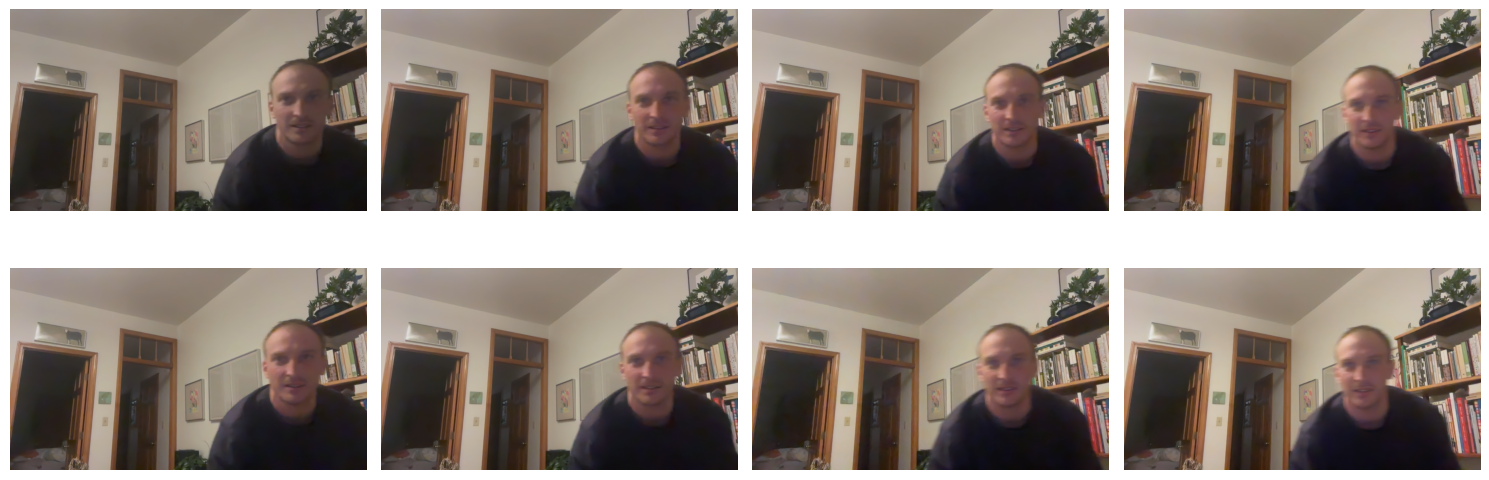

In [46]:
NUM_IMAGES = 8
images = capture_images(NUM_IMAGES).to(device)

fig, axes = plt.subplots(2, NUM_IMAGES // 2, figsize=(15, 6))
for i in range(NUM_IMAGES):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = img.clip(0, 1)
    axes[i % 2, i // 2].imshow(img)
    axes[i % 2, i // 2].axis('off')

plt.tight_layout()

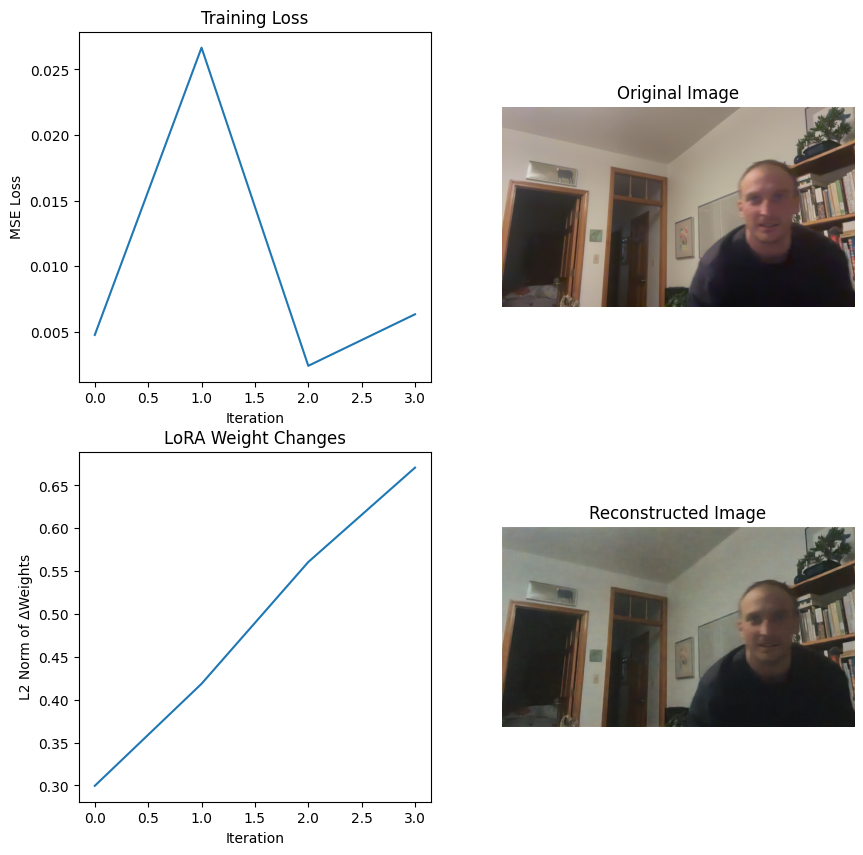

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

%matplotlib inline

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
model.train()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.MSELoss()

batch_size = 8
num_epochs = 50

lora_params_initial = {
    n: p.detach().cpu().clone() 
    for n, p in model.named_parameters() if "delta" in n.lower()
}
print("initial lora params:", lora_params_initial.keys())

# plot over time
lora_param_changes = []
losses = []

fig, axes = plt.subplots(2, 2, figsize=(10,10))
loss_ax = axes[0,0]
weights_ax = axes[1,0]
orig_ax = axes[0,1]
recon_ax = axes[1,1]

for epoch in range(num_epochs):
    for i in range(0, images.size(0), batch_size):
        img = images[i:i+batch_size].to(device)  # shape [B, C, H, W]
        
        out = model(img)
        x_hat = out["x_hat"] if isinstance(out, dict) and "x_hat" in out else out
        
        loss = criterion(x_hat, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # get lora update norms
        current_lora_params = {
            n: p.detach().cpu().clone() 
            for n, p in model.named_parameters() if "delta_" in n.lower()
        }
        diff_norm = 0.0
        for n in lora_params_initial:
            diff_norm += (current_lora_params[n] - lora_params_initial[n]).pow(2).sum().item()
        diff_norm = diff_norm**0.5
        lora_param_changes.append(diff_norm)

        # update display
        clear_output(wait=True)

        # loss plot
        loss_ax.clear()
        loss_ax.plot(losses)
        loss_ax.set_title("Training Loss")
        loss_ax.set_xlabel("Iteration")
        loss_ax.set_ylabel("MSE Loss")

        # lora plot
        weights_ax.clear()
        weights_ax.plot(lora_param_changes)
        weights_ax.set_title("LoRA Weight Changes")
        weights_ax.set_xlabel("Iteration")
        weights_ax.set_ylabel("L2 Norm of ΔWeights")

        mid_idx = batch_size // 2
        orig_img_np = img[mid_idx].detach().cpu().permute(1,2,0).numpy().clip(0,1)
        x_hat_np = x_hat[mid_idx].detach().cpu().permute(1,2,0).numpy().clip(0,1)

        orig_ax.clear()
        orig_ax.imshow(orig_img_np)
        orig_ax.set_title("Original Image")
        orig_ax.axis('off')

        recon_ax.clear()
        recon_ax.imshow(x_hat_np)
        recon_ax.set_title("Reconstructed Image")
        recon_ax.axis('off')

        display(fig)
        # plt.pause(0.001)

print("done")